# COVID19DB PROJECT (www.covid19db.org): covid19 - confirmed cases, administrative division for Germany


This notebook demonstrates how to connect to COVID19db Postgres database and how to generate country level visualisaion.

In [1]:
import psycopg2
import pandas as pd
from pandas.plotting import register_matplotlib_converters 
register_matplotlib_converters()
import matplotlib.pyplot as plt

# Connect to covid19db.org
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19'
)
cur = conn.cursor()
cur.execute("""SELECT i.* FROM
                (SELECT max(date) AS date, countrycode, adm_area_1
                FROM epidemiology WHERE source = %(source)s
                GROUP BY countrycode, adm_area_1 ) AS recent_data
              INNER JOIN epidemiology AS i
              ON i.date=recent_data.date 
              AND i.countrycode = recent_data.countrycode
              AND i.adm_area_1 = recent_data.adm_area_1
              AND i.adm_area_1 <> ''
              AND i.source = %(source)s
              ORDER by i.confirmed DESC
            """, {'source': 'DEU_JPGG'})

covid19_data = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])

In [2]:
covid19_data.head()

,source,date,country,countrycode,adm_area_1,adm_area_2,adm_area_3,tested,confirmed,recovered,dead,hospitalised,hospitalised_icu,quarantined
0,DEU_JPGG,2020-04-10,Germany,DEU,Bayern,None,None,None,30904,None,None,None,None,None
1,DEU_JPGG,2020-04-10,Germany,DEU,Nordrhein-Westfalen,None,None,None,24898,None,None,None,None,None
2,DEU_JPGG,2020-04-10,Germany,DEU,Baden-Württemberg,None,None,None,23969,None,None,None,None,None
3,DEU_JPGG,2020-04-10,Germany,DEU,Niedersachsen,None,None,None,7543,None,None,None,None,None
4,DEU_JPGG,2020-04-10,Germany,DEU,Hessen,None,None,None,5541,None,None,None,None,None


In [3]:
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Polygon

In [4]:
url='http://biogeo.ucdavis.edu/data/diva/adm/DEU_adm.zip'
germany = geopandas.read_file("http://biogeo.ucdavis.edu/data/diva/adm/DEU_adm.zip", layer='DEU_adm1')
germany.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,86,DEU,Germany,1,Baden-Württemberg,Land,State,None,None,"MULTIPOLYGON (((8.70837 47.71556, 8.70918 47.7..."
1,86,DEU,Germany,2,Bayern,Land,State,None,Bavaria,"POLYGON ((10.13386 50.55000, 10.13980 50.54252..."
2,86,DEU,Germany,3,Berlin,Land,State,None,None,"POLYGON ((13.17789 52.39032, 13.16575 52.39050..."
3,86,DEU,Germany,4,Brandenburg,Land,State,None,None,"POLYGON ((13.87951 53.50107, 13.87927 53.49908..."
4,86,DEU,Germany,5,Bremen,Land,State,None,None,"MULTIPOLYGON (((8.50506 53.23289, 8.51754 53.2..."


In [5]:
germany = germany.merge(
    covid19_data[['adm_area_1','tested','confirmed']], 
    how = 'left', left_on = 'NAME_1', right_on = 'adm_area_1'
)
germany.fillna({'confirmed':0}, inplace=True)
# add centroids 
germany['coords'] = germany['geometry'].apply(lambda x: x.centroid.coords[:])
germany['coords'] = [coords[0] for coords in germany['coords']]
germany.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry,adm_area_1,tested,confirmed,coords
0,86,DEU,Germany,1,Baden-Württemberg,Land,State,None,None,"MULTIPOLYGON (((8.70837 47.71556, 8.70918 47.7...",Baden-Württemberg,None,23969,"(9.049365432526331, 48.5485063306352)"
1,86,DEU,Germany,2,Bayern,Land,State,None,Bavaria,"POLYGON ((10.13386 50.55000, 10.13980 50.54252...",Bayern,None,30904,"(11.423220269834882, 48.94689510998228)"
2,86,DEU,Germany,3,Berlin,Land,State,None,None,"POLYGON ((13.17789 52.39032, 13.16575 52.39050...",Berlin,None,4357,"(13.408782477698923, 52.499336205601395)"
3,86,DEU,Germany,4,Brandenburg,Land,State,None,None,"POLYGON ((13.87951 53.50107, 13.87927 53.49908...",Brandenburg,None,1864,"(13.399066360809442, 52.47328028502668)"
4,86,DEU,Germany,5,Bremen,Land,State,None,None,"MULTIPOLYGON (((8.50506 53.23289, 8.51754 53.2...",Bremen,None,453,"(8.74869103850634, 53.1930925192729)"


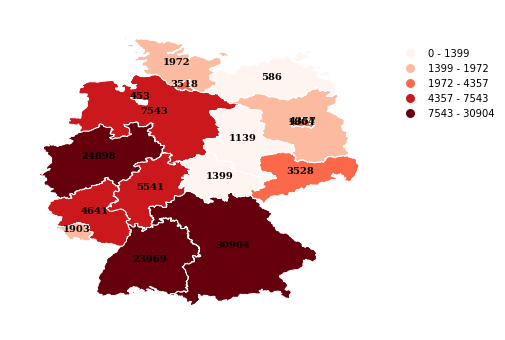

In [6]:
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import geoplot as gplt


schema = mc.Quantiles(germany['confirmed'], k=5)
gplt.choropleth(
    germany,     
    hue='confirmed',     
    edgecolor='white', 
    linewidth=1,
    cmap='Reds',
    scheme=schema,
    legend=True, 
    legend_kwargs={'bbox_to_anchor': (1, 0.9), 'frameon': False},
)

for _, row in germany.iterrows():
  hue = round(row['confirmed'],2)  
  plt.text(s=row['confirmed'], x = row['coords'][0], y = row['coords'][1],
           horizontalalignment='center', 
           fontdict = {'weight': 'bold', 'size': 10, 'family': 'serif', 'color':  'black',})